In [1]:
from matplotlib import pyplot
import seaborn

In [15]:
from metrics.utils import constants

data = "fashion-mnist"
metric = "euclidean"
report_dir = constants.DATA_ROOT.joinpath(data, metric)
tree_path = report_dir.joinpath("tree.arrow")
leaves_path = report_dir.joinpath("leaves.arrow")
distances_path = report_dir.joinpath("query-distances-batch-1-1.npy")

In [16]:
import polars

# Columns: ['name', 'depth', 'left', 'right', 'cardinality', 'arg_center', 'arg_radius', 'radius', 'lfd', 'polar_distance']
tree_df = polars.scan_ipc(tree_path)
print(tree_df.columns)
print(tree_df.head().collect())

['name', 'depth', 'left', 'right', 'cardinality', 'arg_center', 'arg_radius', 'radius', 'lfd', 'polar_distance']
shape: (5, 10)
┌──────┬───────┬──────┬───────┬─────┬────────────┬─────────────┬──────────┬────────────────┐
│ name ┆ depth ┆ left ┆ right ┆ ... ┆ arg_radius ┆ radius      ┆ lfd      ┆ polar_distance │
│ ---  ┆ ---   ┆ ---  ┆ ---   ┆     ┆ ---        ┆ ---         ┆ ---      ┆ ---            │
│ str  ┆ u64   ┆ str  ┆ str   ┆     ┆ u64        ┆ f32         ┆ f32      ┆ f32            │
╞══════╪═══════╪══════╪═══════╪═════╪════════════╪═════════════╪══════════╪════════════════╡
│ 1    ┆ 0     ┆ 2    ┆ 3     ┆ ... ┆ 53579      ┆ 4223.00293  ┆ 1.802554 ┆ 5708.139648    │
│ 2    ┆ 1     ┆ 4    ┆ 5     ┆ ... ┆ 51462      ┆ 3819.630127 ┆ 1.811292 ┆ 5129.637695    │
│ 4    ┆ 2     ┆ 8    ┆ 9     ┆ ... ┆ 51826      ┆ 3512.300293 ┆ 1.54094  ┆ 4870.371582    │
│ 8    ┆ 3     ┆ 10   ┆ 11    ┆ ... ┆ 13195      ┆ 3347.302246 ┆ 1.908424 ┆ 4961.298828    │
│ 10   ┆ 4     ┆ 20   ┆ 21    ┆ ...

In [17]:
selectors = [
    polars.col("radius").quantile(v / 100).alias(f"quantile-{v}")
    for v in range(10, 100, 10)
]

radii: polars.DataFrame = (
    tree_df
    .groupby("depth")
    .agg([
        polars.col("radius").min().alias(f"min"),
        polars.col("radius").quantile(1 / 100).alias(f"quantile-01"),
        *selectors,
        polars.col("radius").quantile(99 / 100).alias(f"quantile-99"),
        polars.col("radius").max().alias(f"max"),
    ])
    .sort("depth")
    .collect()
)
print(radii.head())

shape: (5, 14)
┌───────┬────────────┬───────────┬───────────┬─────┬───────────┬───────────┬───────────┬───────────┐
│ depth ┆ min        ┆ quantile- ┆ quantile- ┆ ... ┆ quantile- ┆ quantile- ┆ quantile- ┆ max       │
│ ---   ┆ ---        ┆ 01        ┆ 10        ┆     ┆ 80        ┆ 90        ┆ 99        ┆ ---       │
│ u64   ┆ f32        ┆ ---       ┆ ---       ┆     ┆ ---       ┆ ---       ┆ ---       ┆ f32       │
│       ┆            ┆ f32       ┆ f32       ┆     ┆ f32       ┆ f32       ┆ f32       ┆           │
╞═══════╪════════════╪═══════════╪═══════════╪═════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 0     ┆ 4223.00293 ┆ 4223.0029 ┆ 4223.0029 ┆ ... ┆ 4223.0029 ┆ 4223.0029 ┆ 4223.0029 ┆ 4223.0029 │
│       ┆            ┆ 3         ┆ 3         ┆     ┆ 3         ┆ 3         ┆ 3         ┆ 3         │
│ 1     ┆ 3819.63012 ┆ 3819.6301 ┆ 3819.6301 ┆ ... ┆ 4301.9990 ┆ 4301.9990 ┆ 4301.9990 ┆ 4301.9990 │
│       ┆ 7          ┆ 27        ┆ 27        ┆     ┆ 23        ┆ 23        ┆

In [18]:
radii.columns

['depth',
 'min',
 'quantile-01',
 'quantile-10',
 'quantile-20',
 'quantile-30',
 'quantile-40',
 'quantile-50',
 'quantile-60',
 'quantile-70',
 'quantile-80',
 'quantile-90',
 'quantile-99',
 'max']

In [19]:
import pandas

radii_pd: pandas.DataFrame = radii.to_pandas()
radii_pd.set_index("depth")
radii_pd.drop("depth", inplace=True, axis=1)
radii_pd.head()

,min,quantile-01,quantile-10,quantile-20,quantile-30,quantile-40,quantile-50,quantile-60,quantile-70,quantile-80,quantile-90,quantile-99,max
0,4223.002930,4223.002930,4223.002930,4223.002930,4223.002930,4223.002930,4223.002930,4223.002930,4223.002930,4223.002930,4223.002930,4223.002930,4223.002930
1,3819.630127,3819.630127,3819.630127,3819.630127,3819.630127,3819.630127,4301.999023,4301.999023,4301.999023,4301.999023,4301.999023,4301.999023,4301.999023
2,3512.300293,3512.300293,3512.300293,3512.300293,3598.773193,3598.773193,3661.643555,3661.643555,3661.643555,3983.971191,3983.971191,3983.971191,3983.971191
3,3279.816406,3279.816406,3279.816406,3311.175049,3322.440918,3334.713379,3347.302246,3347.302246,3361.148193,3408.185791,3606.865723,3606.865723,3606.865723
4,2920.389648,2920.389648,2944.586670,3129.857910,3156.507812,3181.186768,3275.472656,3410.341553,3429.288818,3495.245117,3540.868652,3608.537354,3608.537354


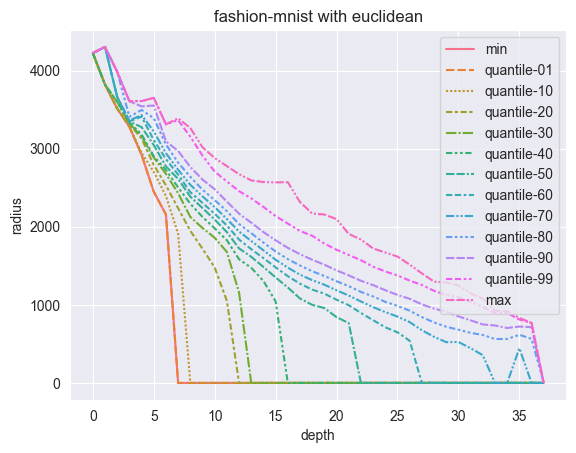

In [20]:
%matplotlib inline

ax = seaborn.lineplot(radii_pd)
ax.set_xlabel("depth")
ax.set_ylabel("radius")
ax.set_title(f"{data} with {metric}")
pyplot.savefig(constants.FIGURES_ROOT.joinpath(f"{data}-{metric}-radius-vs-depth.png"), dpi=300)

In [34]:
import numpy

query_distances = numpy.load(distances_path)
query_distances = query_distances[query_distances.shape[0] // 2:]
print(query_distances.shape, query_distances.dtype)
print(query_distances.min(), query_distances.max())

(10000, 60000) float32
20.808653 5647.357


<Axes: ylabel='Density'>

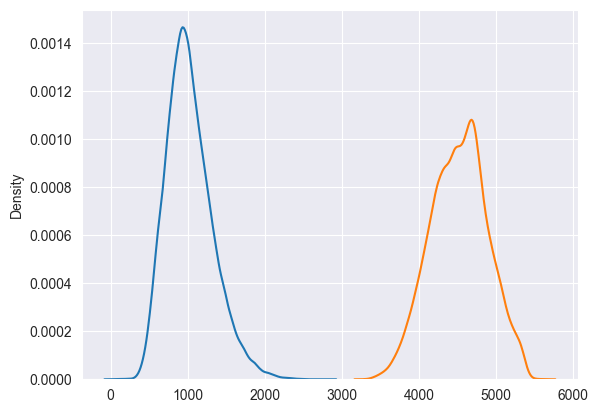

In [35]:
%matplotlib inline

row_min = query_distances.min(axis=0)
row_max = query_distances.max(axis=0)

seaborn.kdeplot(row_min)
seaborn.kdeplot(row_max)

<Axes: ylabel='Count'>

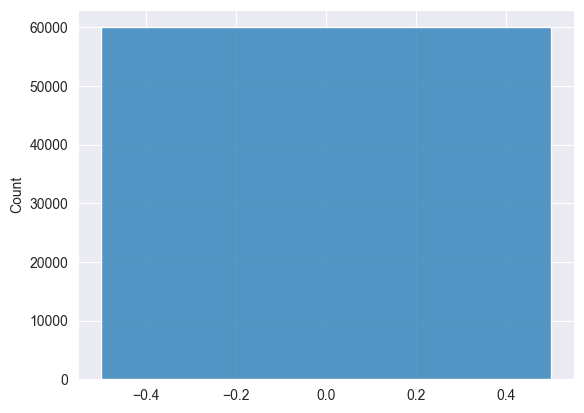

In [24]:
%matplotlib inline

seaborn.histplot(query_distances[0])

In [31]:
import tqdm

100%|██████████| 1000/1000 [02:00<00:00,  8.31it/s]


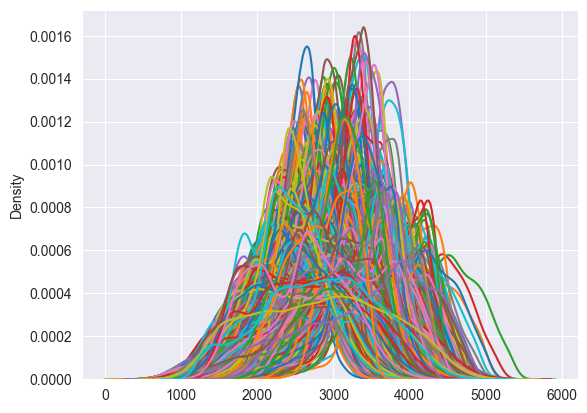

In [33]:
%matplotlib inline

for i in tqdm.tqdm(list(range(10_000, 11_000))):
    seaborn.kdeplot(query_distances[i], warn_singular=False)

In [48]:
kth_distances = numpy.sort(query_distances, axis=1)

In [49]:
print(kth_distances[:5, :10])

[[ 482.2966   681.9905   708.49915  729.6321   762.0374   769.30096
   791.26794  823.932    829.3684   831.49023]
 [1308.002   1329.3134  1382.7317  1387.0912  1393.9028  1400.1586
  1405.0463  1411.8608  1416.281   1417.4392 ]
 [ 466.0322   538.53784  555.87946  599.7641   600.98334  612.703
   630.95166  632.87836  642.7791   655.53644]
 [ 621.72986  663.5375   669.1958   669.6088   674.1224   686.3811
   687.6351   695.90875  702.0598   711.842  ]
 [ 943.05884  974.25867  998.60754 1054.4994  1059.4036  1081.9963
  1082.0605  1084.1886  1092.391   1112.8944 ]]


<Axes: ylabel='Density'>

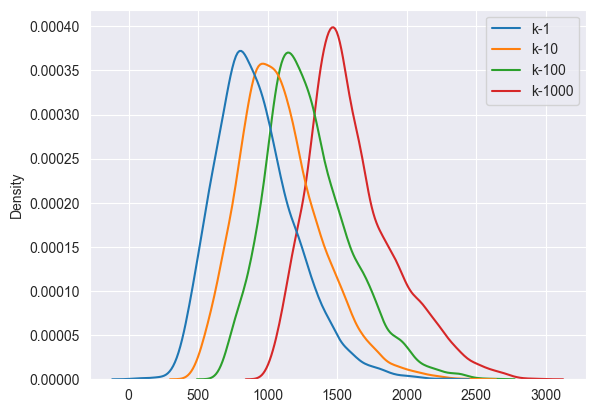

In [50]:
%matplotlib inline

kth_df = pandas.DataFrame(data={
    f"k-{k}": kth_distances[:, k - 1]
    for k in [1, 10, 100, 1000]
})

seaborn.kdeplot(kth_df, warn_singular=False)